In [1]:
from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

In [2]:
def MalhaRetangular(N):
   Δ = 1.0/N
   Δx = Δ; Δy = Δ
   x = API_Numpy.arange(0.0,0.25+Δx,Δx)
   y = API_Numpy.arange(Δy,1.0,Δy)

   X = API_Numpy.stack([x]*y.shape[0],axis=1)
   Y = API_Numpy.stack([y]*x.shape[0],axis=0)

   return X, Y, Δ

In [3]:
def CondiçãoInicialRayleighTaylor(X, Y, γ):
   R = API_Numpy.zeros(X.shape)
   P = API_Numpy.zeros(X.shape)
   U = API_Numpy.zeros(X.shape)
   V = API_Numpy.zeros(X.shape)
   for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      if Y[i,j] < 0.5:
         R[i,j] = 2.0
         P[i,j] = 2.0*Y[i,j] + 1.0
      else:
         R[i,j] = 1.0
         P[i,j] = Y[i,j] + 1.5
         
      a = API_Numpy.sqrt(γ * P[i,j] / R[i,j])
      V[i,j] = -0.025 * a * API_Numpy.cos(8.0*API_Numpy.pi*X[i,j])

   E = P/(γ-1.0) + R*(U**2 + V**2)/2.0
   Q0 = API_Numpy.stack([R, R*U, R*V, E],axis=0)
   return Q0


In [4]:
def CondiçãoInicialRayleighTaylor_N(N, γ):
   X, Y, Δ = MalhaRetangular(N)
   Q0 = CondiçãoInicialRayleighTaylor(X, Y, γ)
   return X, Y, Δ, Q0

In [5]:
def RayleighTaylorGravity(Q):
   g = -1.0
   # for i = 1:size(U,1)
   #    for j = 1:size(U,2)
   #       F[i,j,3] = -g * U[i,j,1]
   #       F[i,j,4] = -g * U[i,j,3]
   #    end
   # end
   Z = API_Numpy.zeros(list(Q.shape[:-3])+[1]+[Q.shape[-2],Q.shape[-1]])
   F = API_Numpy.concat([Z,Z,-g*Q[...,0:1,:,:],-g*Q[...,2:3,:,:]],axis=-3)
   return F

In [6]:
γ = 5.0/3.0
N = 160
x, y, Δ, U0 = CondiçãoInicialRayleighTaylor_N(N, γ)
cfl = 0.6
t_final = 1.95

In [7]:
U0[1,:,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
WENO_Z_sim=simulation_2D(API_Numpy,
                    euler_equation_2D,
                    WENO_Z_pm,
                    map_function=BI_mapping,
                    mapping=pre_inv_mapping)

In [20]:
def RayleighTaylorGhostPointsX(Q,API):
    left=API_Numpy.stack([Q[...,0,:3,:],-Q[...,1,:3,:],Q[...,2,:3,:],Q[...,3,:3,:]],axis=-3)
    left=API_Numpy.reverse(left,axis=-2)

    center=Q

    right=API_Numpy.stack([Q[...,0,-3:,:],-Q[...,1,-3:,:],Q[...,2,-3:,:],Q[...,3,-3:,:]],axis=-3)
    right=API_Numpy.reverse(right,axis=-2)

    return API_Numpy.concat([left,center,right],axis=-2)

def RayleighTaylorGhostPointsY(Q,API):
   ref_shape=list(Q.shape)
   vals_left=API_Numpy.reshape([2.0,0.0,0.0,1.0/(γ-1.0)],len(ref_shape[:-3])*[1]+[4]+[1,1])
   vals_right=API_Numpy.reshape([1.0,0.0,0.0,2.5/(γ-1.0)],len(ref_shape[:-3])*[1]+[4]+[1,1])
   Qg = [API_Numpy.ones(ref_shape[:-1]+[3])*vals_left,
         Q,
        API_Numpy.ones(ref_shape[:-1]+[3])*vals_right]
   return API_Numpy.concat(Qg,-1)

In [21]:
import seaborn
import matplotlib.pyplot as plt

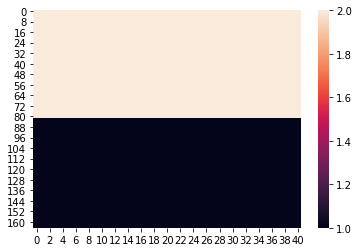

In [22]:
pre_U=RayleighTaylorGhostPointsY(U0,API_Numpy)
seaborn.heatmap(pre_U[0,:,:].T)
plt.show()

In [15]:
from IPython.display import clear_output

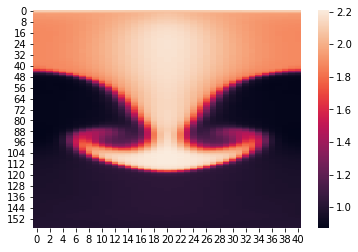

In [17]:
U=U0.copy()
for i in range(int(1.95/0.05)):
    U=WENO_Z_sim.Sim_graph(U, 0.05, Δ, Δ, cfl, RayleighTaylorGhostPointsX, RayleighTaylorGhostPointsY,RayleighTaylorGravity)
    clear_output()
    seaborn.heatmap(U[0].T)
    plt.show()

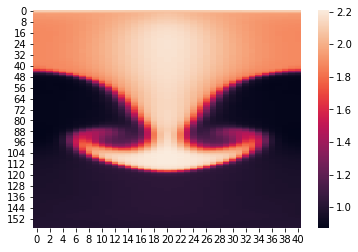

In [ ]:
U=U0.copy()
for i in range(int(1.95/0.05)):
    U=WENO_Z_sim.Sim_graph(U, 0.05, Δ, Δ, cfl, RayleighTaylorGhostPointsX, RayleighTaylorGhostPointsY,RayleighTaylorGravity)
    clear_output()
    seaborn.heatmap(U[0].T)
    plt.show()

In [13]:
U.shape

(4, 41, 159)